In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
pairs = pd.read_csv('matched_pairs.csv')
minutes = set(pairs['minute_id'].tolist())

In [4]:
def get_text_from_minute(identifier):
    """
    Retrieves the HTML content of a document from the officielebekendmakingen.nl API
    """
    # Retrieve the html content
    html = requests.get(f"https://zoek.officielebekendmakingen.nl/{identifier}.html")
    soup = BeautifulSoup(html.content, "html.parser")

    # Check if there is a web-version available (#content .alert contains text: 'niet beschikbaar als Webversie)
    alert = soup.find(id="content").find("div", class_="alert")
    if alert is not None and "niet beschikbaar als Webversie" in alert.get_text():
        raise ValueError(f"[web] Web version not available for {identifier}.")


    # Find the first <article> tag inside #content
    article = soup.find(id="content").find("article")
    if article is None:
        raise ValueError(f"[article] Article tag not found in HTML content for {identifier}.")
    text = article.get_text(separator=' ', strip=True)
    return str(text)

# Retrieve the text for each minute identifier
texts = []
for minute in minutes:
    try:
        text = get_text_from_minute(minute)
        texts.append(text)
    except ValueError as e:
        print(e)
print(f"Retrieved text for {len(texts)} minutes.")

Retrieved text for 5 minutes.


In [5]:
# Calculate the number of sentences and words in total
total_sentences = 0
total_words = 0

for text in texts:
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    total_sentences += len(sentences)
    total_words += len(words)
print(f"Total words: {total_words}")
print(f"Total sentences: {total_sentences}")

Total words: 33990
Total sentences: 1841


In [6]:
# Analyze the matched pairs

anno_sentences = set()  # Set to store unique sentences from annotations
anno_total_words = 0  # Total words in annotations
word_count_arr =  np.array([], dtype=int) # Array to store the number of words in each annotation
for i, pair in pairs.iterrows():
    words = word_tokenize(pair['text_a'])
    anno_sentences.add(pair['sentence_a'])
    anno_total_words += len(words)
    word_count_arr = np.append(word_count_arr, len(words))
print(f"Total words in annotations: {anno_total_words} ({anno_total_words / total_words:.2%} of total words)")
print(f"Total sentences in annotations: {len(anno_sentences)} ({len(anno_sentences) / total_sentences:.2%} of total sentences)")

Total words in annotations: 568 (1.67% of total words)
Total sentences in annotations: 88 (4.78% of total sentences)


<Figure size 1000x600 with 0 Axes>

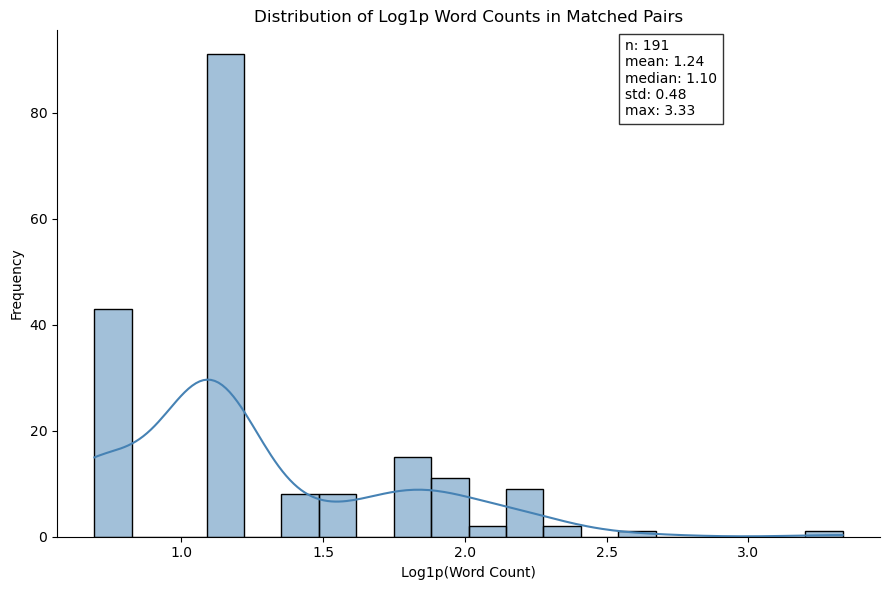

In [8]:
# Log-normalize the word lengths (adding 1 to avoid log(0))
word_lengths = np.log1p(word_count_arr.copy())

# Create the displot
plt.figure(figsize=(10, 6))
sns.displot(
    word_lengths,
    kde=True,
    height=6,
    aspect=1.5,
    bins=20,
    color='steelblue'
)

plt.title('Distribution of Log1p Word Counts in Matched Pairs')
# plt.title('Distribution of Word Counts in Matched Pairs (Log-normalized)')
plt.xlabel('Log1p(Word Count)')
plt.ylabel('Frequency')

# Add some statistics as text
plt.figtext(
    0.7, 0.8,
    f"n: {len(word_lengths)}\n"
    f"mean: {np.mean(word_lengths):.2f}\n"
    f"median: {np.median(word_lengths):.2f}\n"
    f"std: {np.std(word_lengths):.2f}\n"
    f"max: {np.max(word_lengths):.2f}",
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.show()